<a href="https://colab.research.google.com/github/Mandlez/Finance/blob/main/Monte_Carlo_simulation_for_european_call.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pandas_datareader

In [ ]:
# Import dependencies
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

# What is Monte Carlo Simulation

Monte Carlo simulations is a way of solving probabilistic problems by numerically simulating many possible scenarios so that you may calculate statistical properties of the outcomes, such as expectations, variances of probabilities of certain outcomes.

In the case of Financial Derivatives, this gives us a handy tool for which to price complex derivatives for which and analytical formulae is not possible.



In [ ]:
# initial derivative parameters
S = 102.25          #stock price
K = 98.05          #strike price
vol = 0.15        #volatility (%)
r = 0.05           #risk-free rate (%)
N = 10              #number of time steps
M = 1000            #number of simulations

market_value = 5.27 #market price of option
T = ((datetime.date(2024,3,17)-datetime.date(2024,1,17)).days+1)/365    #time in years
print(T)

0.16712328767123288


## Slow Solution

In [ ]:
# Precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0

# Monte Carlo Method
for i in range(M):
    lnSt = lnS
    for j in range(N):
        lnSt = lnSt + nudt + volsdt*np.random.normal()

    ST = np.exp(lnSt)
    CT = max(0, ST - K)
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT

# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $5.66 with SE +/- 0.16



## Fast Solution - Vectorized


In [ ]:
#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_lnSt = nudt + volsdt*Z
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )

# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r*T)*np.sum(CT[-1])/M

sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $5.73 with SE +/- 0.17


## Visualisation of Convergence

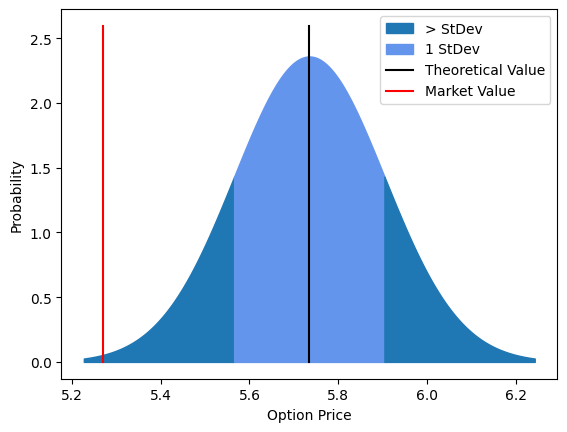

In [ ]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')

plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()